# Introducing the Keras Sequential API

**Learning Objectives**
  - Build a DNN model using the Keras Sequential API
  - Learn how to use feature columns in a Keras model
  - Learn how to save/load, and deploy a Keras model on GCP

## Introduction

The Keras sequential API allows you to create models layer-by-layer. This is useful for building most kinds of machine learnig models but it does not allow you to create models that share layers or have multiple inputs or outputs.


In [38]:
!pip3 freeze | grep tf-nightly-2.0-preview || pip3 install tf-nightly-2.0-preview

tf-nightly-2.0-preview==2.0.0.dev20190731


In [39]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

In [40]:
print(tf.__version__)

2.0.0-dev20190731


In [41]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Sep  5 14:51 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Sep  5 14:51 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Sep  5 14:51 ../data/taxi-valid.csv


In [4]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [5]:
!head ../data/taxi-test.csv

6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9


In [6]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             .cache())
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
    return dataset

This is an obligatory parameter for fit_generator() API, that marks the end of training for a single epoch. Since the data generator function continuously feeds training samples into the fit_generator() API, it is not possible to know the end of an epoch unless the parameter steps_per_epoch is specified.

In [25]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # input layer of feature columns
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }

    # create DNN using Sequential API
    model = tf.keras.models.Sequential()    
    model.add(tf.keras.layers.DenseFeatures(feature_columns=feature_columns.values()))
    model.add(tf.keras.layers.Dense(units=32, activation="relu", name="h1"))
    model.add(tf.keras.layers.Dense(units=8, activation="relu", name="h2"))
    model.add(tf.keras.layers.Dense(units=1, activation="linear", name="output"))

    # compile the keras model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    
    return model

model = build_dnn_model()

In [26]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

In [27]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5
312/312 [==============================] - 2s 8ms/step - loss: 172.5048 - rmse: 16.1406 - mse: 416.2003 - val_loss: 111.1927 - val_rmse: 10.5298 - val_mse: 111.1927
Epoch 2/5
312/312 [==============================] - 1s 3ms/step - loss: 99.2017 - rmse: 9.2860 - mse: 100.5246 - val_loss: 112.0889 - val_rmse: 10.5715 - val_mse: 112.0890
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 95.6585 - rmse: 9.0210 - mse: 92.2778 - val_loss: 111.4399 - val_rmse: 10.5425 - val_mse: 111.4399
Epoch 4/5
312/312 [==============================] - 1s 3ms/step - loss: 103.7886 - rmse: 9.3836 - mse: 102.2809 - val_loss: 111.1609 - val_rmse: 10.5284 - val_mse: 111.1609
Epoch 5/5
312/312 [==============================] - 1s 3ms/step - loss: 97.0146 - rmse: 9.1754 - mse: 94.6163 - val_loss: 111.2442 - val_rmse: 10.5329 - val_mse: 111.2442


In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


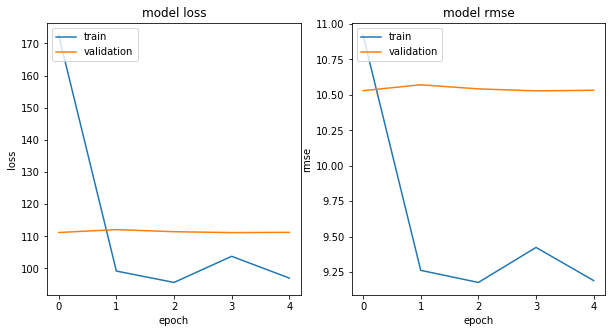

In [29]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

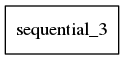

In [30]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=True, rankdir='LR')

In [31]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

array([[12.23408]], dtype=float32)

In [32]:
import shutil, os, datetime
OUTPUT_DIR = './export/savedmodel'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

W0908 21:31:05.045247 140415247824640 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1784: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20190908213104
./export/save

In [35]:
%%bash
PROJECT=munn-sandbox
BUCKET=${PROJECT}
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=dnn

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.14 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

taxifare already exists
Creating taxifare:dnn


In [36]:
%%writefile input.json
{"pickup_longitude": -73.982683, "pickup_latitude": 40.742104,"dropoff_longitude": -73.983766,"dropoff_latitude": 40.755174,"passenger_count": 3.0}  

Writing input.json


In [37]:
!gcloud ai-platform predict --model taxifare --json-instances input.json --version dnn

ERROR: (gcloud.ai-platform.predict) HTTP request failed. Response: {
  "error": {
    "code": 500,
    "message": "Internal error encountered.",
    "status": "INTERNAL"
  }
}

